# Login

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install huggingface_hub -q
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


# Import and download

In [3]:
!pip install transformers -q
!pip install datasets -q

import transformers

     |████████████████████████████████| 4.2 MB 19.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 346 kB 24.0 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 140 kB 70.2 MB/s 
     |████████████████████████████████| 1.1 MB 69.1 MB/s 
     |████████████████████████████████| 212 kB 77.9 MB/s 
     |████████████████████████████████| 127 kB 61.0 MB/s 
     |████████████████████████████████| 271 kB 69.2 MB/s 
     |████████████████████████████████| 144 kB 94.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 67.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!wget https://github.com/alibashir/aav/raw/main/allseqs_20191230.csv.zip --no-verbose
!unzip allseqs_20191230.csv.zip
!rm allseqs_20191230.csv.zip

2022-06-07 11:53:04 URL:https://raw.githubusercontent.com/alibashir/aav/main/allseqs_20191230.csv.zip [8437043/8437043] -> "allseqs_20191230.csv.zip" [1]
Archive:  allseqs_20191230.csv.zip
  inflating: allseqs_20191230.csv    


#Dataset

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("./allseqs_20191230.csv")
df.shape

(296970, 7)

In [6]:
df.head(2)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True


In [7]:
df['sequence']= df['sequence'].str.upper()
df.head(2)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,ADEEIRATNPIATEMYGSVSTNLQLGNR,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,ADEEIRATNPVATEQYGSVSTNQQRQNR,designed,AD____A_______________Q__Q__,5,5,-0.429554,True


In [8]:
df['sequence'] = df['sequence'].apply(lambda seq : " ".join(seq.upper()))
df.head(2)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,A D E E I R A T N P I A T E M Y G S V S T N L ...,designed,AD____A___I___M_________L___,6,6,-2.027259,False
1,A D E E I R A T N P V A T E Q Y G S V S T N Q ...,designed,AD____A_______________Q__Q__,5,5,-0.429554,True


In [9]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df = df.sample(frac=1).reset_index(drop=True)

#df_train = df.sample(frac = 0.90).reset_index(drop=True)
#df_test = df.drop(list(df_train.index)).reset_index(drop=True)

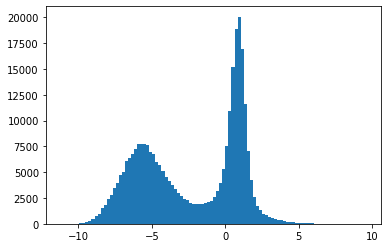

In [11]:
import matplotlib.pyplot as plt

plt.hist(df.viral_selection, bins=100)
plt.show()

# sequence tokenization

In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd")
max_length=50

def tokenize_function(examples):
    return tokenizer(examples['sequence'], padding="max_length", max_length=max_length, return_tensors="tf")

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
train_seqs = df['sequence'].tolist()
train_ids = tokenizer(train_seqs, add_special_tokens=True, padding='max_length', max_length=50, return_tensors="tf")

input_ids = train_ids['input_ids']
attention_mask = train_ids['attention_mask']
token_type_ids = train_ids['token_type_ids']

In [14]:
y_train = np.asarray(df['viral_selection'])
y_train

array([ 1.63746491,  1.88242268, -6.98816244, ..., -2.0472729 ,
       -7.40974278,  2.7071413 ])

# BERT model for embedding

In [15]:
from transformers import TFAutoModel

model = TFAutoModel.from_pretrained("Rostlab/prot_bert_bfd", 
                                    from_pt=True, output_hidden_states=True
                                    )

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

# Freeze all BERT layer

In [ ]:
# Let's print the layers of the model
for layer in model.layers[:]:
    print(layer)

In [ ]:
for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        print(layer.embeddings)
        print(layer.encoder)
        print(layer.pooler)

In [ ]:
for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for layer in layer.encoder.layer:
            print(layer)

In [ ]:
#freeze all encoder layer

for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for idx, layer in enumerate(layer.encoder.layer):
           if idx in range(30):
              layer.trainable = False


for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for idx, layer in enumerate(layer.encoder.layer):
           print(layer, layer.trainable)

In [ ]:
#freeze embeddings and pooler layer

for layer in model.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
      layer.embeddings.trainable = False
      layer.pooler.trainable = False

In [ ]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  419931136 
                                                                 
Total params: 419,931,136
Trainable params: 0
Non-trainable params: 419,931,136
_________________________________________________________________


# Add regression layer

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam


input_ids = tf.keras.Input(shape=(max_length,), dtype='int32')
token_type_ids = tf.keras.Input(shape=(max_length,), dtype='int32')
attention_mask = tf.keras.Input(shape=(max_length,), dtype='int32')

output = model([input_ids, token_type_ids, attention_mask])    
output = output['pooler_output']
output = tf.keras.layers.Dense(1, input_shape=(None,1024))(output)

regressor = tf.keras.models.Model(inputs = [input_ids, token_type_ids, attention_mask], 
                                  outputs = output)


regressor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  419931136   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]',            

# Tokenization for huggingface format

In [17]:
df['labels'] = df['viral_selection'] * 1

In [18]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[['sequence','labels']])
dataset

Dataset({
    features: ['sequence', 'labels'],
    num_rows: 296896
})

In [19]:
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)

df_train = dataset['train']
df_test = dataset['test']

df_test = df_test.train_test_split(test_size=0.25, shuffle=True)
df_val = df_test['train']
df_test = df_test['test']

df_train, df_val, df_test

(Dataset({
     features: ['sequence', 'labels'],
     num_rows: 237516
 }), Dataset({
     features: ['sequence', 'labels'],
     num_rows: 44535
 }), Dataset({
     features: ['sequence', 'labels'],
     num_rows: 14845
 }))

In [20]:
df_train[2]

{'labels': 0.8394432448519142,
 'sequence': 'D E E E I R T T N P V A T E Q Y G V V S T V Q N G N Q Q S A T E E G T T V E'}

In [21]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
max_length=50

def preprocess_function(examples):
    return tokenizer(examples['sequence'], padding="max_length", max_length=max_length)

In [22]:
df_train = df_train.map(preprocess_function, batched=True)
df_val = df_val.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x7f8308d207a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/238 [00:00<?, ?ba/s]

  0%|          | 0/45 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [23]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

In [24]:
batch_size = 32

In [25]:
tf_train = df_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_val = df_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test = df_test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# test on validation set (before training)

In [26]:
predictions = classifier.predict(tf_val)["logits"]
predicted_class = np.squeeze(predictions)

NameError: ignored

In [27]:
predicted_class

NameError: ignored

In [ ]:
y_test = list(map(lambda x: x['labels'], df_val))
y_test = np.asarray(y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predicted_class, s=1)
plt.xlabel("viral_selection_experimental")
plt.ylabel("predicted")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score     #(y_true, y_pred, *)

array1 = np.asarray(y_test)
array2 = np.asarray(predicted_class)


mae = mae(array1,array2)
mse = mse(array1,array2)
r2_score = r2_score(array1,array2)

mae, mse, r2_score

# Fine-tune the model

In [ ]:
from transformers import TFAlbertForSequenceClassification

classifier = TFAlbertForSequenceClassification.from_pretrained("Rostlab/prot_albert", from_pt=True, num_labels=1)

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/856M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertForSequenceClassification: ['sop_classifier.classifier.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import create_optimizer
import tensorflow as tf

num_epochs = 4
batches_per_epoch = len(df_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=300, num_train_steps=total_train_steps)

In [ ]:
import tensorflow as tf

classifier.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer)

history = classifier.fit(
    tf_train,
    validation_data=tf_val,
    epochs=num_epochs
)

In [ ]:
np.save('/content/drive/MyDrive/AAV2_viability/output/my_history.npy',history.history) #for saving history
#history=np.load('my_history.npy',allow_pickle='TRUE').item() #for loading

#classifier.save('/content/drive/MyDrive/AAV2_viability/output/')
#model = keras.models.load_model('path/to/location')

# test on validation set (after training)

In [ ]:
import os

predictions = classifier.predict(tf_val)["logits"]
predicted_class = np.squeeze(predictions)

output_test_file = os.path.join('./', "val_results.txt")
with open(output_test_file, "w") as writer:
  writer.write("index\tprediction\n")
  for index, item in enumerate(predicted_class):
    writer.write(f"{index}\t{item:3.9f}\n")

In [ ]:
y_test = list(map(lambda x: x['labels'], df_val))
y_test = np.asarray(y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predicted_class, s=1)
plt.xlabel("viral_selection_experimental")
plt.ylabel("predicted")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score     #(y_true, y_pred, *)

array1 = np.asarray(y_test)
array2 = np.asarray(predicted_class)


mae = mae(array1,array2)
mse = mse(array1,array2)
r2_score = r2_score(array1,array2)

mae, mse, r2_score

# test on test set

In [ ]:
import os

predictions = classifier.predict(tf_test)["logits"]
predicted_class = np.squeeze(predictions)

output_test_file = os.path.join('./', "test_results.txt")
with open(output_test_file, "w") as writer:
  writer.write("index\tprediction\n")
  for index, item in enumerate(predicted_class):
    writer.write(f"{index}\t{item:3.9f}\n")

In [ ]:
y_test = list(map(lambda x: x['labels'], df_test))
y_test = np.asarray(y_test)

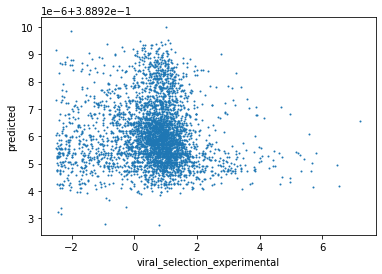

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predicted_class, s=1)
plt.xlabel("viral_selection_experimental")
plt.ylabel("predicted")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score     #(y_true, y_pred, *)

array1 = np.asarray(y_test)
array2 = np.asarray(predicted_class)


mae = mae(array1,array2)
mse = mse(array1,array2)
r2_score = r2_score(array1,array2)

mae, mse, r2_score

(0.8425567247063669, 1.3079210645375754, -0.038439379096709025)

# Upload to huggingface hub

In [ ]:
new_model_name = 'AAV2-Albert-regressor'

classifier.push_to_hub(new_model_name)
tokenizer.push_to_hub(new_model_name)